In [84]:
import numpy as np
import lcm
import drc as lcmdrc
import matplotlib.pyplot as plt
%matplotlib inline  

In [3]:
pathToLogFolder = "/media/manuelli/DATA/logs/CASE/"
filename = "lcmlog__2016-02-26__19-34-23-163082__CPF_add_multi_contact_2"
fullFilename = pathToLogFolder + filename

In [5]:
log = lcm.EventLog(fullFilename, 'r')
print 'reading %s' % filename
print 'log file size: %.2f MB' % (log.size()/(1024.0**2))
startTime = 0.0
endTime = None

reading lcmlog__2016-02-26__19-34-23-163082__CPF_add_multi_contact_2
log file size: 893.54 MB


In [54]:
def getTime(msg):
    return 1.0*msg.utime/1e6

def handleContactFilterPointMsg(msg):
    d = {'t': getTime(msg)}
    d['numContacts'] = msg.num_contact_points
    d['squaredError'] = msg.logLikelihood
    return d

def handleSingleContactLocationMsg(msg):
    d = {}
    d['linkName'] = msg.link_name
    d['contactLocation'] = np.array(msg.contact_location_in_world)
    return d

def handleContactLocationMsg(msg):
    d = {}
    d['numContacts'] = msg.num_contacts
    d['contacts'] = []
    
    for singleMsg in msg.contacts:
        d['contacts'].append(handleSingleContactLocationMsg(singleMsg))
        
    return d

def handleActualAndEstimatedContactLocationMsg(msg):
    d = {'t': getTime(msg)}
    
    msgActual = msg.actual_contact_location
    msgEstimated = msg.estimated_contact_location
    d['actual'] = handleContactLocationMsg(msgActual)
    d['estimated'] = handleContactLocationMsg(msgEstimated)
    return d

In [55]:
cfpDictList = []
cfpDataList = []
for event in log:
    if event.channel == "CONTACT_FILTER_POINT_ESTIMATE":
        msg = lcmdrc.contact_filter_estimate_t.decode(event.data)
        cfpDictList.append(handleContactFilterPointMsg(msg))
        
    if event.channel == "ACTUAL_AND_ESTIMATED_CONTACT_LOCATIONS":
        msg = lcmdrc.actual_and_estimated_contact_locations_t.decode(event.data)
        cfpDataList.append(handleActualAndEstimatedContactLocationMsg(msg))
    

In [63]:
def computeDistanceToClosestPoint(actual, estContacts):
    distList = []
    for est in estContacts:
        dist = np.linalg.norm(actual['contactLocation'] - est['contactLocation'])
        distList.append(dist)
    
    return np.min(np.array(distList))


def computeEstimationError(d):
    d_est = d['estimated']
    d_act = d['actual']
    
    if d_act['numContacts'] == d_est['numContacts']:
        error = d_act['numContacts']*[None]
        for idx, actual in enumerate(d_act['contacts']):
            actual['error'] = computeDistanceToClosestPoint(actual, d_est['contacts'])
            

In [64]:
print len(cfpDictList)
print len(cfpDataList)

1205
736


In [67]:
for d in cfpDataList:
    computeEstimationError(d)

In [80]:
d = cfpDataList[300]
print d

{'estimated': {'numContacts': 2, 'contacts': [{'linkName': u'utorso', 'contactLocation': array([ 0.95587635, -0.06625859,  1.46736896])}, {'linkName': u'l_larm', 'contactLocation': array([ 0.83648545,  0.48617011,  0.90633321])}]}, 'actual': {'numContacts': 2, 'contacts': [{'linkName': u'utorso', 'contactLocation': array([ 0.95639282, -0.06286536,  1.46322334]), 'error': 0.0053820914094717008}, {'linkName': u'l_larm', 'contactLocation': array([ 0.83332741,  0.49154097,  0.9094336 ]), 'error': 0.0069592894151645057}]}, 't': 1095.82974}


In [99]:
cfpDataList = cfpDataList[0:20]
time = np.zeros(len(cfpDataList))
error = np.zeros((3,len(cfpDataList)))
for idx, d in enumerate(cfpDataList):
    time[idx] = d['t']
    for idx_inner, a in enumerate(d['actual']['contacts']):
        if a.has_key('error'):
            error[idx_inner, idx] = a['error']
        

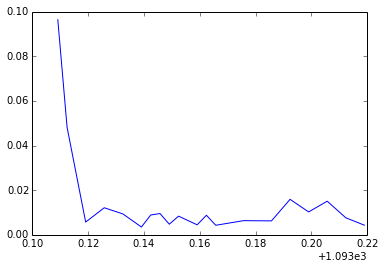

In [100]:
plt.plot(time, error[0,:])
# plt.plot(time, error[1,:])
# plt.plot(time, error[2,:])

In [90]:
np.size(error)

900